# Exercises focusing on Image Segmentation

In [1]:
import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps
from PIL import Image

import cv2

from image_processing_exercises import utils


## S1a. Contour extraction using MM erosion or dilation

In [2]:
def s1a_contour_extraction(img: Image) -> Image:
    img = PIL.ImageOps.invert(img.convert("RGB"))
    erosion_img = utils.erosion(img, i=1, method="mask")
    return Image.fromarray(np.array(img) - np.array(erosion_img))



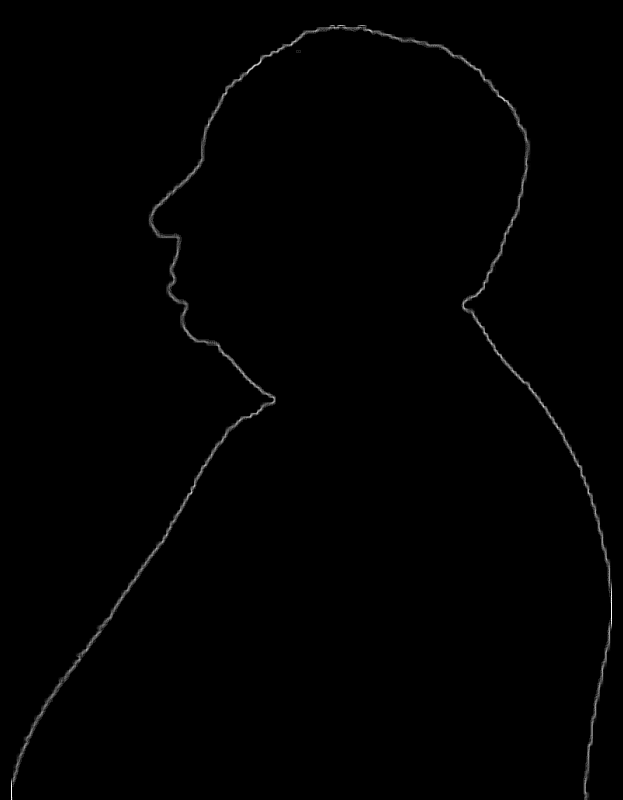

In [3]:
test_image = utils.get_image("segmentation", "hitchcock", "png")
s1a_contour_extraction(test_image)


## S1b.Grassfire propagation algorithm

In [4]:
def get_neighbors(img_arr, p, connectivity=8, size=1):
    i, j = p
    neighbors = set()

    if connectivity == 8:
        for x in range(max(i - size, 0), min(i + size, img_arr.shape[0] - 1) + 1):
            for y in range(max(j - size, 0), min(j + size, img_arr.shape[1] - 1) + 1):
                if x == i and y == j:
                    continue  # a pixel is not its own neighbor, in case of size = 0 an empty set is returned
                neighbors.add((x, y))

    elif connectivity == 4:
        for x in [-1, 1]:
            new_x = i + x
            if 0 <= new_x < img_arr.shape[0]:
                neighbors.add((new_x, j))
        for y in [-1, 1]:
            new_y = j + y
            if 0 <= (j + y) <= img_arr.shape[1]:
                neighbors.add((i, new_y))

    else:
        raise ValueError(f"Unknown connectivity value '{connectivity}'")

    return neighbors


# S1b.Grassfire propagation algorithm
def s1b_grassfire(img: Image) -> dict:

    img_arr = np.array(img)

    regions = {}
    counter = 0

    white_pixels_idx = np.transpose(np.nonzero(img_arr == 255))

    overall_to_check = set(tuple(p) for p in white_pixels_idx)

    while len(overall_to_check) > 0:

        to_check = [overall_to_check.pop()]
        region = set()

        # finds one region
        while len(to_check) > 0:
            p = to_check.pop(0)
            region.add(p)

            neighbors = {
                n for n in get_neighbors(img_arr, p) if img_arr[n] == img_arr[p]
            }

            to_check.extend(list(neighbors - (region.union(set(to_check)))))

        regions[counter] = region
        overall_to_check -= region
        counter += 1

    return regions



In [5]:
particles_image = utils.get_image("segmentation", "particles", "png").convert("L")

for k, v in s1b_grassfire(particles_image).items():
    print(f"Region {k} contains {len(v)} pixels")


Region 0 contains 980 pixels
Region 1 contains 366 pixels
Region 2 contains 543 pixels
Region 3 contains 109 pixels
Region 4 contains 109 pixels
Region 5 contains 109 pixels
Region 6 contains 667 pixels
Region 7 contains 109 pixels
Region 8 contains 109 pixels
Region 9 contains 109 pixels
Region 10 contains 109 pixels
Region 11 contains 109 pixels
Region 12 contains 109 pixels
Region 13 contains 109 pixels
Region 14 contains 109 pixels
Region 15 contains 109 pixels
Region 16 contains 109 pixels
Region 17 contains 109 pixels
Region 18 contains 109 pixels
Region 19 contains 109 pixels
Region 20 contains 109 pixels


In [6]:
def _get_n_colors(num_colors):
    # get n distinct colors
    cm = plt.get_cmap("gist_rainbow")
    cNorm = colors.Normalize(vmin=0, vmax=num_colors - 1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_ls = [scalarMap.to_rgba(i)[:3] for i in range(num_colors)]
    return color_ls



In [7]:
def color_regions(img: Image) -> Image:

    regions = s1b_grassfire(img)
    colors_ls = _get_n_colors(max(regions.keys()) + 1)

    img_arr_rgb = np.array(img.convert("RGB"))
    for i, ls in regions.items():
        for p in ls:
            img_arr_rgb[p] = np.array(colors_ls[i]) * 255

    return Image.fromarray(img_arr_rgb)



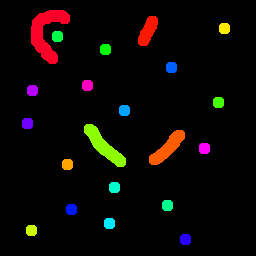

In [8]:
color_regions(particles_image)


In [9]:
### S1c Counting of wheel teeth

In [10]:
def diff_images(img_one, img_two):
    return Image.fromarray(np.array(img_one) - np.array(img_two))



In [11]:
def s1c_wheel_teeth_count():

    gear_image = utils.get_image("segmentation", "wheel", "png").convert("L")

    processed_image = utils.opening_closing_alternated_filter(
        diff_images(
            gear_image,
            utils.opening(gear_image, 5),  # this value result of experimentation
        ),
        1,
    )

    regions = s1b_grassfire(processed_image)
    regions_cnt = (
        max(regions.keys()) - 1
    )  # we have to subtract one since regions are 0 indexed

    teeth_cnt = (
        regions_cnt - 3
    )  # there are 3 regions in the middle that I cannot get rid of by filtering alone :(

    print(f"Detected {teeth_cnt} teeth in wheel")
    return processed_image, teeth_cnt



Detected 118 teeth in wheel


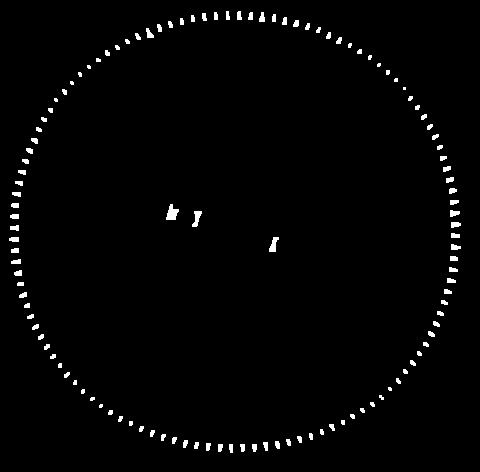

In [12]:
processed_img, _ = s1c_wheel_teeth_count()
processed_img


## S1d.Coffee grains watershed markers

In [13]:
def s1d_coffee_train_watershed_markers():

    # https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html
    coffee_image = utils.get_image("segmentation", "coffee_grains", "jpg").convert(
        "RGB"
    )

    coffee_image_inv = PIL.ImageOps.invert(coffee_image).convert("L")

    coffee_image_inv_thres = utils.threshold_image(coffee_image_inv, 100)

    i = utils.closing(coffee_image_inv_thres, 1)  # remove noise from the image

    dist_transform = cv2.distanceTransform(
        np.array(i), cv2.DIST_L2, 3
    )  # distance from next black Pixel
    ret, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

    sure_fg_p = Image.fromarray(np.array(sure_fg, dtype="uint8"))
    sure_fg_p = utils.opening(sure_fg_p, 2)

    return sure_fg_p



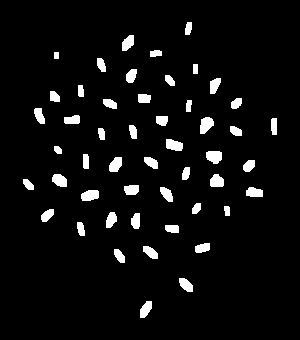

In [14]:
markers = s1d_coffee_train_watershed_markers()
markers


In [15]:
bean_regions = s1b_grassfire(markers)
print(f"I count {max(bean_regions)-1} beans")


I count 48 beans
